# Django rest framework私房手册

## 官方文档

- [官方文档](https://www.django-rest-framework.org/)
- [官方文档中文版](http://www.iamnancy.top/djangorestframework/Home/)
- [一个可浏览的参考，包含完整的方法和属性](http://www.cdrf.co/)

## rest framework的基本流程

很多人觉得Django rest framework简单，但其实个人觉得不是很好上手。因为需要对Django的各方面概念都比较熟悉，对整个框架都有一定了解才能熟练掌握，而且为了保持灵活性和扩展性，不论是django，还是django rest framework，都采用了大量的mixin混入类，这又加大了理解的难度。

因此，最好是先从整体结构上理解它，然后再研究和掌握细节，否则只能够依样画葫芦的抄一抄官网的代码，很难进行扩展。先从整体上看基本的流程：

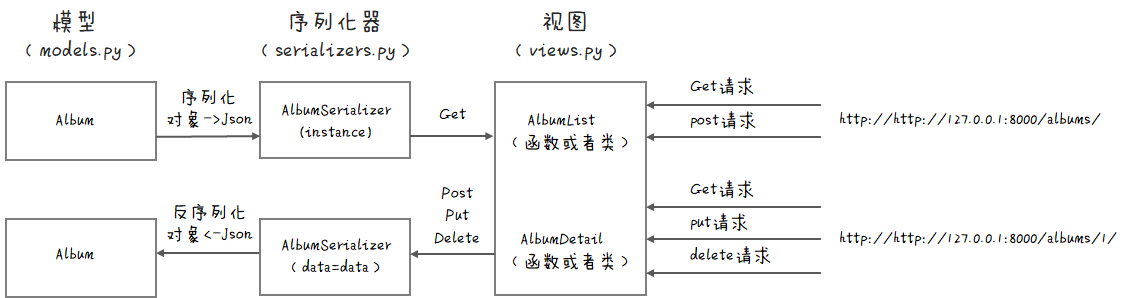

可见，一个request请求到一个response响应，主要几个环节：
1. 对于get请求，获取单个或多个model实例，然后通过序列化器将其序列化成json对象，然后返回。
2. 对于post，put或者delete请求，将传入的json对象通过序列化器，创建、更新或者删除model实例。
3. 获取多个model实例，以及创建单个model实例，对应一个API，也就是一个url地址，格式为：`http://ipaddress/model_name/`, 其对应着视图模块的一个类或者一个函数。
4. 获取或者更新，删除一个model实例，对应一个API，也就是另一个url地址，格式为：`http://ipaddres/model_name/<pk>/`, 对应着视图模块的一个类或者一个函数。

因此，最重要的就是序列化器以及视图，其中：
1. 序列化器负责模型对象和json对象之间的转换。
2. 视图接收request请求，如果是get请求，需要先获取model实例，通过序列化器完成转换，并将结果返回给客户端。如果是post、put、delete请求，则直接通过序列化器解析传递过来的数据，并完成新增、更新或者删除操作，此时模型的增、删、改操作都由序列化器代理完成。

## 序列化器

## 序列化器中的关系型字段

关系型字段要熟练掌握是比较难的，这里主要是对官方文档一些不清晰或者难以理解的地方加以说明：
- [官方中文文档](http://www.iamnancy.top/djangorestframework/Serializer-relations/)

为了说明此节的内容，建立如下模型:
```python
class Album(models.Model):
    album_name = models.CharField(max_length=100, unique=True)
    artist = models.CharField(max_length=100)

    def __str__(self):
        return f"《{self.album_name}》"


class Track(models.Model):
    album = models.ForeignKey(Album, related_name='tracks', on_delete=models.CASCADE)
    order = models.IntegerField()
    title = models.CharField(max_length=100)
    duration = models.IntegerField()

    class Meta:
        unique_together = ['album', 'order']
        ordering = ['album']

    def __str__(self):
        return '%d: %s' % (self.order, self.title)
```

### 反向关系注意事项

当模型中存在关系型字段时，即包含`ForeignKey`多对一，`OneToOneField`一对一，以及`ManyToManyField`多对多字段时，反向关系的字段不会自动包含在 `ModelSerializer`和`HyperlinkedModelSerializer`类中，通过未定义外键的模型关联定义了外键的模型就叫反向关系，如上的例子，外键设置在`Track`模型中，因此`Album`的序列化器如果要显示`Track`字段，需要在`fields`中明确的写出来，如果`fields`设置为`__all__`，默认不会显示。如下：
```python
class AlbumSerializer(serializers.ModelSerializer):

    class Meta:
        model = Album
        fields = ['album_name', 'artist', 'tracks']  # 如果fields设置为__all__，则不会显示track字段
```
其中`fields`中的`tracks`对应`Track`模型中`album`字段的`related_name`，即通过`Album`反向引用`Track`时的引用名称。如果没有设置`related_name`，默认为Django自动生成的名称，即模型名称的小写加上`_set`，这里的话就是`track_set`。

### 关系型字段的类型

序列化器一共有5种关系型的字段，如下：
- `StringRelatedField`：返回模型实例的字符串形式。即`__str__`方法返回的结果。
- `PrimaryKeyRelatedField`：默认的关系型字段类型，返回模型实例的主键。
- `HyperlinkedRelatedField`：返回一个链接来表示对应的模型实例。
- `SlugRelatedField`：返回模型实例的某个字段来表示该模型实例。
- `HyperlinkedIdentityField`：

#### PrimaryKeyRelatedField

`PrimaryKeyRelatedField`是默认的关系型字段类型，不需要使用类属性进行声明，返回的是模型实例的主键，比如如下的序列器：
```python
class AlbumSerializer(serializers.ModelSerializer):

    class Meta:
        model = Album
        fields = ['album_name', 'artist', 'tracks']
```
返回的结果如下：
```json
[
    {
        "album_name": "昨日重现",
        "artist": "卡朋特",
        "tracks": [
            5
        ]
    },
    {
        "album_name": "过火",
        "artist": "张信哲",
        "tracks": [
            3,
            4
        ]
    }
```
对于它的关键字参数，有几点需要注意：
- `many`：注意，如果是一对多的关系，比如上例中，专辑对应着多个曲目，则必须要将`many`设置为`True`，否则会报错。
- `queyrset`：使用`PrimaryKeyRelatedField`，默认情况下，要么，将`read_only`关键字参数设置为`True`，表示只读，如果想要可写的话，即能通过`post`请求新增条目，必须设置`queryset`关键字参数为关联模型的一个查询结果集。<font color="red">**注意：`read_only`仅仅只是指此外键是否可写，并不是指模型本身不能新增记录。**</font>就像下面这样：
```python
class AlbumSerializer(serializers.ModelSerializer):
    tracks = serializers.PrimaryKeyRelatedField(many=True, queryset=Track.objects.all())

    class Meta:
        model = Album
        fields = ['album_name', 'artist', 'tracks']
```
当发送`post`请求新增条目时，会根据主键`pk`在`queryset`返回的结果集中进行查找，比如如下的序列器：
```python
class AlbumSerializer(serializers.ModelSerializer):
    tracks = serializers.PrimaryKeyRelatedField(many=True, queryset=Track.objects.filter(id__gt=5))

    class Meta:
        model = Album
        fields = ['album_name', 'artist', 'tracks']
```
意味着新增条目时，`tracks`只能包含大于5的`pk`值，如果`post`的数据，`pk`值小于5，则会返回错误：
```json
{
    "album_name": "安妮",
    "artist": "王杰",
    "tracks": [1,2]
}
```
返回的结果为：
```json
{
    "tracks": [
        "无效主键 “1” － 对象不存在。"
    ]
}
```
注意：此时仅仅只是新增了`Album`的条目，并没有新增`Track`实例，而是将已有的`Track`实例的`album_id`<font color="red">**更新、更新、更新（重要的事情说3遍！）**</font>为新增的`Album`实例的主键，比如原来的`Track`的前两条记录：
![3.png](pic/3.png)

`post`如下的请求：
```json
{
    "album_name": "安妮",
    "artist": "王杰",
    "tracks": [1,2]
}
```
现在`Track`前两条记录变成：
![4.png](pic/4.png)
`album_id`7就是新增的`album`实例：

对于这种反向关系的写入，一般情况下主表和次表都是希望新增记录，因此这种处理逻辑非常容易出错。所以，强烈建议将`read_only`设置为`True`，注意，上面已经提到过，再重复一次，`read_only`只是指这个外键的实例，这里就是`Track`的实例不可更新，模型本身，即`Album`仍然可以新增实例。就像下面这样：
```python
class AlbumSerializer(serializers.ModelSerializer):
    tracks = serializers.PrimaryKeyRelatedField(many=True, read_only=True)

    class Meta:
        model = Album
        fields = ['album_name', 'artist', 'tracks']
```
再次`post`请求：
```json
{
    "album_name": "安妮",
    "artist": "王杰"
}
```
此时添加了`Album`的记录。<font color="red">**注意：此时`post`的数据仍然可以包含`tracks`，不会报错，只是不会更新track实例罢了。**</font>
```json
{
    "album_name": "安妮",
    "artist": "王杰",
    "tracks": [1,2]  // 仍然可以这样写，不会报错，只是不会更新track。
}
```
不得不说，rest framework官网关于`queryset`参数的使用以及关系型字段的写入描述的太过简单，而且逻辑实现的非常的不清晰，很容易出错。

那么，如果想要实现新增`Album`的同时新增`Track`实例怎么办呢？只能覆写`Album`序列器的`create`方法，如下：
```python
class AlbumSerializer(serializers.ModelSerializer):
    tracks = TrackSerializer(many=True)

    class Meta:
        model = Album
        fields = ('album_name', 'artist', 'tracks')

    def create(self, validated_data):
        tracks_data = validated_data.pop('tracks')
        album = Album.objects.create(**validated_data)
        for track_data in tracks_data:  # 必须提供track完整的内容，否则无法新增
            Track.objects.create(album=album, **track_data)
        return album
```
因此，如果要同时新增两个模型的实例，最好还是按照常规的流程，分两步，先新增`Album`实例，然后再新增`Track`实例。

#### StringRelatedField

可以在类声明中将外键设置为其它类型的关系型字段，比如`StringRelatedField`类型，`StringRelatedField`类型的字段返回模型实例的字符串形式。即`__str__`方法返回的结果。比如如下定义的序列器：
```python
class AlbumSerializer(serializers.ModelSerializer):
    tracks = serializers.StringRelatedField(many=True)

    class Meta:
        model = Album
        fields = ['album_name', 'artist', 'tracks']
```
返回结果是这样的：
```json
[
    {
        "album_name": "昨日重现",
        "artist": "卡朋特",
        "tracks": [
            "1: 卡萨布兰卡"
        ]
    },
    {
        "album_name": "过火",
        "artist": "张信哲",
        "tracks": [
            "1: 宽容",
            "2: 爱如潮水"
        ]
    }
```
注意，`StringRelatedField`只有一个关键字参数`many`，没有`queryset`，也就意味着该外键字段只能读取，无法更新。其内部已经将`read_only`设置为`True`。也很容易理解，因为无法根据`StringRelatedField`返回的字符串找到外键对应的模型实例，比如上面的例子，无法通过`"1: 卡萨布兰卡"`这样的字符串找到相应的`Track`的实例。

#### HyperlinkedRelatedField

`HyperlinkedRelatedField`将外键关联的实例显示为url地址，默认要提供`view_name`参数，否则会报错，如果使用`rest framework`的路由器注册的路由，那么这个例子中的`view_name`为`track-detail`，为每个`track`实例的url地址，`view_name`参数的详细解释参考路由器一节，比如下面的序列器：
```python
class AlbumSerializer(serializers.ModelSerializer):
    tracks = serializers.HyperlinkedRelatedField(many=True, read_only=True, view_name='track-detail')

    class Meta:
        model = Album
        fields = ['album_name', 'artist', 'tracks']
```
返回的结果如下：
```json
[
    {
        "album_name": "昨日重现",
        "artist": "卡朋特",
        "tracks": [
            "http://127.0.0.1:8000/tracks/5/"
        ]
    },
    {
        "album_name": "过火",
        "artist": "张信哲",
        "tracks": [
            "http://127.0.0.1:8000/tracks/3/",
            "http://127.0.0.1:8000/tracks/4/"
        ]
    }
]
```
注意两个关键字参数：`lookup_field`和`lookup_url_kwarg`，需要和视图的这两个属性保持一致，具体解释见视图一节，这里简单解释一下，`lookup_field`是内部模型用来查找具体实例的字段，默认为`pk`，即数据库中设置为`primary key`的字段，`lookup_url_kwarg`是url中定义的关键字参数，比如`track-detail`的API接口地址为`http://127.0.0.1/tracks/<int:pk>/`，其中的`pk`就是`lookup_url_kwarg`。

默认情况下，`HyperlinkedRelatedField`字段是可写的，不过要注意的是，写入的时候，需要`post`的是主键的值，而不能是url地址。如下：
```json
{
    "album_name": "宽容",
    "artist": "张信哲",
    "tracks": [
        1,
        2
    ]
}
```
同样的，此时对于`Track`模型来说，并不是新增一个`Track`实例，仅仅只是将`Track`实例的`album_id`更新为新增的`album`实例的主键。

#### SlugRelatedField

`SlugRelatedField`将外键关联的实例显示为模型的某个字段，需要传递`slug_field`参数，即模型字段的名称，如下：
```python
class AlbumSerializer(serializers.ModelSerializer):
    tracks = serializers.SlugRelatedField(many=True, slug_field="title", queryset=Track.objects.all())

    class Meta:
        model = Album
        fields = ['album_name', 'artist', 'tracks']
```
返回的结果为：
```json
[
    {
        "album_name": "昨日重现",
        "artist": "卡朋特",
        "tracks": [
            "卡萨布兰卡"
        ]
    },
    {
        "album_name": "过火",
        "artist": "张信哲",
        "tracks": [
            "宽容",
            "爱如潮水"
        ]
    }
]
```
注意：`SlugRelatedField`写入的时候，需要post的是定义的`slug_field`字段的值，不是主键的值。如下：
```json
{
    "album_name": "海阔天空",
    "artist": "beyond",
    "tracks": ["爱你一万年"]
}
```
后台会在`queryset`返回的结果集中运行`Track.objects.all().filter(title='爱你一万年')`来返回`Track`实例。所以，特别注意，此时的`slug_field`需要是唯一的，如果不唯一，返回多个结果，则会报错。所以建议只有模型中`unique`设置为`True`的字段才使用`SlugRelatedField`。

#### HyperlinkedIdentityField

官网的例子有点问题，如下：
```python
class AlbumSerializer(serializers.HyperlinkedModelSerializer):
    track_listing = serializers.HyperlinkedIdentityField(view_name='track-list')

    class Meta:
        model = Album
        fields = ('album_name', 'artist', 'track_listing')
```
个人理解，`HyperlinkedIdentityField`应该是配置路由时，url名称对应的地址，如果是使用路由器注册的，那么自动生成的url名称`track-list`对应的地址应该是`http://127.0.0.1:8000/tracks/`，因此，返回结果应该是：
```json
[
    {
        "album_name": "昨日重现",
        "artist": "卡朋特",
        "tracks": "http://127.0.0.1:8000/tracks/"
    },
    {
        "album_name": "过火",
        "artist": "张信哲",
        "tracks": "http://127.0.0.1:8000/tracks/"
    }
]
```
不过这个结果明显不合理，`http://127.0.0.1:8000/tracks/`，这个地址是所有`track`的API接口，在实际测试中，始终报错，提示反向解析`track-list`出错，可能是内部进行了限制。如果设置为`track-detail`则可以成功返回，结果如下：
```json
[
    {
        "album_name": "昨日重现",
        "artist": "卡朋特",
        "tracks": "http://127.0.0.1:8000/tracks/1/"
    },
    {
        "album_name": "过火",
        "artist": "张信哲",
        "tracks": "http://127.0.0.1:8000/tracks/2/"
    }
]
```
不过结果仍然是有问题的，`tracks`应该是列表。不知道是bug还是故意为之，这个字段和`HyperlinkedRelatedField`的区别在于，`HyperlinkedRelatedField`关系字段的名称不能随便起，比如：
```python
class AlbumSerializer(serializers.ModelSerializer):
    tracks = serializers.HyperlinkedRelatedField(many=True, read_only=True, view_name='track-detail')

    class Meta:
        model = Album
        fields = ['album_name', 'artist', 'tracks']
```
字段的名称`tracks`是`Track`模型中`album`字段`related_name`关键字参数的值，用来反向引用`Track`模型，而`HyperlinkedIdentityField`的关系字段名字随便起，它只是根据`view_name`来查找对应的`url`地址。

总之，除非是一对一的关系或者多对一的关系，否则，尽量不要用这个字段吧。

### 嵌套的序列化器

除了可以使用关系型的字段，还可以直接使用序列化器作为字段，这样返回的是嵌套的json对象，如下：
```python
class AlbumSerializer(serializers.ModelSerializer):
    tracks = TrackSerializer(many=True)

    class Meta:
        model = Album
        fields = ['album_name', 'artist', 'tracks']
```
返回的json如下：
```json
[
    {
        "album_name": "昨日重现",
        "artist": "卡朋特",
        "tracks": [
            {
                "id": 5,
                "order": 1,
                "title": "卡萨布兰卡",
                "duration": 300,
                "album": 1
            }
        ]
    },
    {
        "album_name": "过火",
        "artist": "张信哲",
        "tracks": [
            {
                "id": 3,
                "order": 1,
                "title": "宽容",
                "duration": 330,
                "album": 2
            },
            {
                "id": 4,
                "order": 2,
                "title": "爱如潮水",
                "duration": 280,
                "album": 2
            }
        ]
    }
]
```
注意，字段名仍然是`Track`模型中`album`字段`related_name`参数的值，不能随意命名。内部实际上是反向关联了`Track`的实例然后使用`TrackSerializer`序列化器进行序列化。嵌套的序列化器默认不能写入，如果未明确声明`read_only=True`，会抛出错误，如果声明了，则会新增`Album`实例，`Track`实例会被忽略。

如果要写入，需要覆写`create`方法，如下：
```python
class AlbumSerializer(serializers.ModelSerializer):
    tracks = TrackSerializer(many=True)

    class Meta:
        model = Album
        fields = ('album_name', 'artist', 'tracks')

    def create(self, validated_data):
        tracks_data = validated_data.pop('tracks')
        album = Album.objects.create(**validated_data)
        for track_data in tracks_data:
            Track.objects.create(album=album, **track_data)
        return album  # 根据rest framework的规范，最后要返回新增的Album实例，作为post请求的返回结果。
```

## 基于函数的视图

## 基于类的视图

基于类的视图之间的关系比较复杂，先来看一个简单的关系图捋一捋：
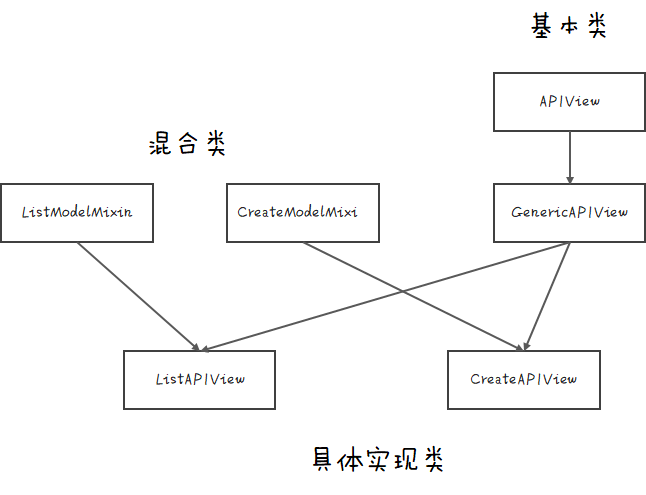
混合类和具体实现类不止图中的几个，这里仅仅只是展示它们之间的关系，具体可以查官方文档。

`APIView`是Django的`View`的子类，在`View`的基础上，包装了原生的`HttpRequest`请求和`HttpResponse`响应，并且提供一些类属性形式的入口，将请求分派给处理程序方法（即`post`,`get`,`put`,`patch`,`delete`方法），之前将运行适当的权限和/或限流检查，或者指定渲染器，解析器等等。

`GenericAPIView`在此基础上增加了`queryset`和`serializer_class`两个类属性指定模型和序列化器，各种混合类提供`create`,`list`,`retrieve`,`update`,`destroy`方法实现模型和序列化器之间的转换逻辑，最终的具体实现类则通过多重继承，实现一个映射，将客户端的请求映射到混合类的对应方法，比如`post`映射到`create`方法，`get`映射到`list`或者`retrieve`方法。

### `APIView`

当业务逻辑不涉及到模型的增删改查，可以直接继承`APIView`类，比如实现一个用户登录的API，客户端发送一个`post`请求，包含用户名和密码的`json`对象，如果成功登录，则返回`{status: '登录成功'}`的`json`对象，如果登录失败，则返回`{staus: '登录失败'}`：
```python
from django.contrib.auth import authenticate, login


class UserLoginView(APIView):
    def post(self, request, *args, **kwargs):
        username = request.data.pop("username", None)
        password = request.data.pop("password", None)
        user = authenticate(username=username, password=password)
        if user is not None:
            login(request, user)
            return Response({"status": "登录成功"}, status=status.HTTP_200_OK)
        else:
            return Response({"status": "登录失败，请检查用户名密码"}, status=status.HTTP_401_UNAUTHORIZED)
```
`APIView`提供了一些类属性，用来指定实现某些特殊功能的类，以`permission_classes`为例，它可以实现权限检查。如以下的简单接口：
```python
class SimpleAPI(APIView):
    permission_classes = (IsAuthenticated,)

    def get(self, request, *args, **kwargs):
        return Response({"name": "telecomshy"})
```
当用户未登录的时候，返回的是：
```json
{
    "detail": "身份认证信息未提供。"
}
```
详细API可以查看[官方文档](http://www.iamnancy.top/djangorestframework/Views/)

### 通用视图

### 钩子方法

有时候，需要修改`post`，`update`请求发送过来的数据再保存到数据库，先来梳理一下整个流程，以`post`请求为例：
1. 视图接收到一个`post`请求，通过继承的`dispatch`方法分发到具体实现类，比如`CreateAPIView`提供的`post`方法，`post`方法内部，调用继承自`CreateModelMixin`的`create`方法。
2. `create`方法内部，通过继承自`GenericAPIView`的`get_serializer`方法获取由`serializer_class`类属性定义的序列化器，然后调用`perform_create`方法。默认情况下，`perform_create`内部，仅仅只是调用了`serializer.save()`方法。
3. 在`serializer.save()`内部，再选择调用`serializer.create()`或者`serializer.update()`方法。

因此，有两个入口适合进行这种修改：
1. 重写视图的`perform_create(self，serializer)`，`perform_update(self，serializer)`以及`perform_destroy(self，instance)`方法。
2. 重写序列化器的`create(self, validated_data)`或者`update(self, instance, validated_data)`方法。

## 视图集

## 常见错误

### post json数据时，出现`JSONDecodeError: Expecting property name enclosed in double quotes`错误

post json格式的数据时，格式的要求比较严格，最后一个键值对，不能有逗号，否则相当于多了一个空的键值对，导致解析报错：
```json
{
 "key1": "value1",
 "key2": "value2",  # 错误，不能有逗号
 }
```

## 引申阅读

- [什么是RESTful API以及Django RestFramework](https://www.jianshu.com/p/e90b26163cc5)